# Vectorization Methods and Classification

In the previous notebook (`1-Text-Preprocessing`), we've created a text pre-processing pipeline.

Here, we're going to apply the `TF-IDF` and `Word2Vec` vectorization methods to our preprocessed data and test it on some supervised machine learning algorithms.


### Importing Libraries

In [24]:
import zipfile
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

# Load preprocessing pipeline created in the previous notebook
from utils import text_preprocessing

# seaborn config
sns.set(font_scale=1.2)
sns.set_palette("pastel")

# Defining some colors
gray = "#9E9E9E"
blue = "#4285F4"

### Loading Data

In [2]:
# Reading the zipfile containing the datasets
zf = zipfile.ZipFile("data/olist-datasets.zip")

# Loading the order reviews dataset
reviews_df = pd.read_csv(zf.open("olist_order_reviews_dataset.csv"),
                         parse_dates=['review_creation_date', 
                                      'review_answer_timestamp'])

# Removing Orders without a written review
reviews_df = (reviews_df[['review_comment_message', 'review_score']]
              .dropna(subset=["review_comment_message"])).reset_index(drop=True)
print(f"> We have {len(reviews_df)} written reviews.")
reviews_df.head()

> We have 40977 written reviews.


,review_comment_message,review_score
0,Recebi bem antes do prazo estipulado.,5
1,Parabéns lojas lannister adorei comprar pela I...,5
2,aparelho eficiente. no site a marca do aparelh...,4
3,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4
4,"Vendedor confiável, produto ok e entrega antes...",5


## 1. Creating our target
___

As we mentioned before, we are going to be working with **supervisioned machine learning algorithms** and try to predict the review score. But, as we saw in our EDA (`0-Exploratory-Data-Analysis.ipynb`), the score distribution is highly imbalanced in 5 different categories (1, 2, 3, 4 and 5).

So, instead of working with multiple classes we'll transform our problem into a binary classification problem.

We are going to split the written reviews as follows:
- **[1]** Positive Reviews: review_score > 3
- **[0]** Negative Reviews: review_score <= 3


In [17]:
reviews_df["positive_review"] = reviews_df['review_score'].apply(lambda x: 1 if x>3 else 0)
reviews_df.sample(5)

,review_comment_message,review_score,preprocessed_review,positive_review
19915,Ótima entrega rápida excelente loja comprarei ...,5,otim entreg rap excel loj compr sempr,1
18217,"Fiquei bem chateado, estalou esperando meu pro...",1,fiq bem chate estal esper produt agor fic sab ...,0
17185,Não efetuou a entrega,1,negaca efetu entreg,0
35822,"Produto perfeito entregue antes do prazo,recom...",5,produt perfeit entreg ant praz recom loj,1
32016,Entregue a tempo e em condições,5,entreg temp condico,1


- **Target distribution:**

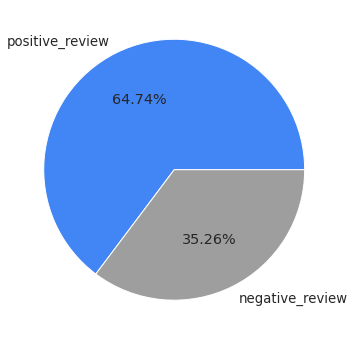

In [32]:
target_count = (reviews_df['positive_review']
                .value_counts()
                .rename({1: "positive_review",
                     0: "negative_review"}))

# Pie Chart
plt.figure(figsize=(14,6))
plt.pie(target_count, 
        labels = target_count.index,
        colors = [blue, gray],
        autopct='%.2f%%')
plt.show()

## 1. Preprocessing Data
___

First, let's run our preprocessing pipeline on our data:

In [3]:
# Loading the portuguese stopwords and nltk stemmer
stopwords_ptbr = nltk.corpus.stopwords.words("portuguese")
nltk_stemmer = nltk.RSLPStemmer()

# Running our preprocessing pipeline
reviews_df['preprocessed_review'] = [text_preprocessing(text, stopwords_ptbr, nltk_stemmer)
                                     for text in reviews_df['review_comment_message']]

In [4]:
reviews_df

,review_comment_message,review_score,preprocessed_review
0,Recebi bem antes do prazo estipulado.,5,receb bem ant praz estipul
1,Parabéns lojas lannister adorei comprar pela I...,5,parab loj lannist ador compr internet segur pr...
2,aparelho eficiente. no site a marca do aparelh...,4,aparelh efici sit marc aparelh impress numer d...
3,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4,pouc trav val ta boa
4,"Vendedor confiável, produto ok e entrega antes...",5,vend confia produt ok entreg ant praz
...,...,...,...
40972,para este produto recebi de acordo com a compr...,4,produt receb acord compr realiz
40973,Entregou dentro do prazo. O produto chegou em ...,5,entreg dentr praz produt cheg condico perfeit ...
40974,"O produto não foi enviado com NF, não existe v...",3,produt negaca envi nf negaca exist vend nf cer...
40975,"Excelente mochila, entrega super rápida. Super...",5,excel mochil entreg sup rap sup recom loj
